### 4.4.4 多项式回归

In [47]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

为训练集和测试集各生成100个样本

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
print(f'{true_w.shape = }')

features = np.random.normal(size=[n_train + n_test, 1])
np.random.shuffle(features)
print(f'{features.shape = }')

poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
print(f'{poly_features.shape = }')

for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # i的阶乘

labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
print(f'{labels.shape = }')

true_w.shape = (20,)
features.shape = (200, 1)
poly_features.shape = (200, 20)
labels.shape = (200,)


In [3]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2], labels[:2]

(tensor([[-1.5449],
         [ 0.2566]]),
 tensor([[ 1.0000e+00, -1.5449e+00,  1.1933e+00, -6.1450e-01,  2.3733e-01,
          -7.3330e-02,  1.8881e-02, -4.1669e-03,  8.0467e-04, -1.3812e-04,
           2.1338e-05, -2.9968e-06,  3.8581e-07, -4.5848e-08,  5.0592e-09,
          -5.2105e-10,  5.0310e-11, -4.5719e-12,  3.9239e-13, -3.1905e-14],
         [ 1.0000e+00,  2.5657e-01,  3.2913e-02,  2.8148e-03,  1.8054e-04,
           9.2642e-06,  3.9615e-07,  1.4520e-08,  4.6565e-10,  1.3274e-11,
           3.4058e-13,  7.9437e-15,  1.6984e-16,  3.3519e-18,  6.1427e-20,
           1.0507e-21,  1.6848e-23,  2.5427e-25,  3.6243e-27,  4.8940e-29]]),
 tensor([-4.3114,  5.1812]))

对模型进行训练和测试

In [5]:
d2l.evaluate_loss

<function d2l.torch.evaluate_loss(net, data_iter, loss)>

In [21]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400, test_use=False):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])

    train_iter = d2l.load_array([train_features, train_labels.reshape(-1, 1)], batch_size)
    test_iter = d2l.load_array([test_features, test_labels.reshape(-1, 1)], batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log', xlim=[1, num_epochs], ylim=[1e-3, 1e2], legend=['train', 'test'])

    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)  # 手动求平均
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, [d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)])

    if test_use:
        # 练习题也用下这个函数
        # 计算单个复杂度时, 模型最终的 [训练集]和 [验证集] 误差
        # 也不要打印权重了
        return d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)

    print('weight:')
    print(net[0].weight.data.numpy())

    return None

三阶多项式函数拟合 (正常)

D:\exec_code\Python\D2DL\venv\lib\site-packages\d2l\torch.py:3406: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  self.data = [a + float(b) for a, b in zip(self.data, args)]


weight:
[[ 5.009567   1.2387439 -3.407729   5.5391817]]


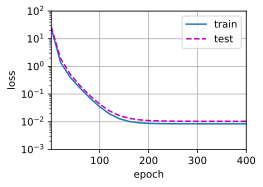

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

线性函数拟合 (欠拟合)

weight:
[[3.032021 4.220153]]


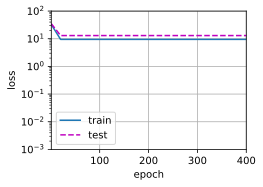

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

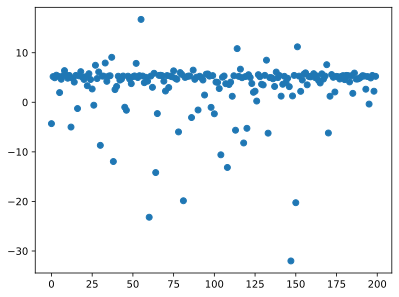

In [12]:
plt.scatter(range(len(labels)), labels)

高阶多项式函数拟合 (过拟合)

weight:
[[ 4.977604    1.3315032  -3.266126    5.086773   -0.35441005  1.217599
  -0.07791027  0.09965035  0.15475942 -0.19511409 -0.0419585   0.11094593
   0.04001756  0.0379438  -0.14384171  0.08304463 -0.03627972  0.21407384
  -0.06238383  0.08492708]]


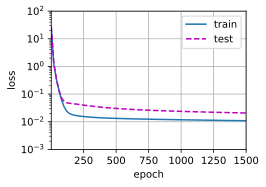

In [14]:
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)

绘制训练损失与模型复杂度的关系图

In [ ]:
final_loss_list = []  # 里面放元组, 元组的第一项是最终的训练集误差, 元组的第二项是最终的验证集误差

for degree in range(1, max_degree + 1):
    final_loss_list.append(train(poly_features[:n_train, 0:degree], poly_features[n_train:, 0:degree], labels[:n_train], labels[n_train:], num_epochs=1500, test_use=True))

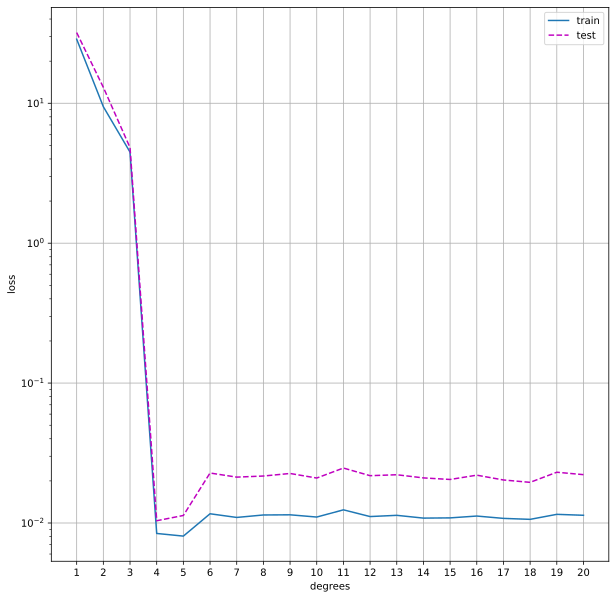

In [50]:
d2l.plot(list(range(1, max_degree + 1)), list(zip(*final_loss_list)), 'degrees', 'loss', ['train', 'test'], figsize=[10, 10], yscale='log')